In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math 
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, LassoCV, lars_path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sn
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files 
uploaded = files.upload()
import pandas as pd 
import io 
soccer = pd.read_csv(io.BytesIO(uploaded['Soccer - Final Data Set.csv'])) 

Saving Soccer - Final Data Set.csv to Soccer - Final Data Set.csv


In [ ]:
#Filtering the Data Set
soccer = soccer.drop(['Stadium Capacity', 'Wins', 'Average Attendance', 'Losses', 'Goals', 'Shots', 'Shots on Goal', 'Cum. Attendance', 'Losing Percentage', 'Games Played', '+/-', 'Draws', 'Total Points', 'Squad size', 'Penalty Kick Attempts', 'Penalty Kick Goals', 'Corner Kicks', 'Assists', 'Average Player Value (M)'], axis = 1)
soccer


,TEAMS,Google Trends Interest,Cum. Player Value (M),Year,Average PCT Attended,Average Age,Foreigners,Winning Percentage,Team Values (M),Revenue (M),Conference Champion,Goals per game,Shot Accuracy,Fouls Committed,Fouls Suffered,Offsides
0,ATL,292,69.78,2019,0.719,23.7,19,0.529,500,78,0,1.706,0.114,350,419,56
1,CHI,224,22.83,2019,0.200,25.0,19,0.294,335,23,0,1.618,0.115,407,374,61
2,COL,381,19.83,2019,0.709,24.6,14,0.353,190,18,0,1.706,0.120,407,368,49
3,COLUMB,260,26.98,2019,0.737,25.4,22,0.294,200,18,0,1.147,0.099,398,366,55
4,DCU,87,32.75,2019,0.887,24.6,17,0.382,330,41,0,1.235,0.098,387,405,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Real Salt Lake City,57,8.78,2015,0.997,25.2,17,0.324,108,24,0,1.118,0.102,436,480,70
99,DCU,82,8.70,2015,0.812,25.3,12,0.441,140,23,0,1.265,0.115,461,379,89
100,DAL,554,7.83,2015,0.781,25.0,21,0.529,148,24,1,1.529,0.130,413,412,57
101,New England Revolution,458,7.55,2015,0.981,24.6,7,0.412,158,27,0,1.412,0.124,463,458,63


In [ ]:
soccer = pd.get_dummies(data=soccer, columns=['TEAMS', 'Year'], drop_first=True)

In [ ]:
soccer.isnull().values.any()

False

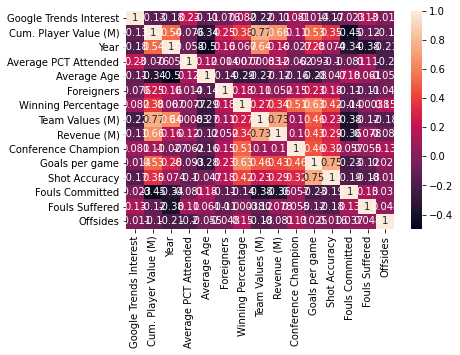

In [ ]:
#Heat Map to show variable correlation
corrmatrix = soccer.corr()
sn.heatmap(corrmatrix, annot=True)
plt.show()

In [ ]:
import math
ratio = list(input('ratio numbers: ').replace(' ', '.'))

KeyboardInterrupt: ignored

In [ ]:
#Set X and y variables before variable selection
y =soccer['Team Values (M)']
X = soccer.drop(['Team Values (M)'], axis = 1)
X = sm.add_constant(X)

In [ ]:
#OLS Variable Selection

soccer_ols = sm.OLS(y.astype(float), X.astype(float)).fit()
soccer_ols.summary()

ValueError: ignored

From this it is important to note that the variables that are significant are, Google Trend Interes, Cum. Player Value (M), Revenue (M), Goals per game, and shot accuracy.

In [ ]:
#Rerun OLS model with the significant variables
X = X.drop(['Average PCT Attended', 'Average Age', 'Foreigners', 'Winning Percentage', 'Conference Champion', 'Fouls Committed', 'Fouls Suffered', 'Offsides'], axis = 1)
soccer_ols = sm.OLS(y, X).fit()
soccer_ols.summary()
X = X.drop(['Shot Accuracy'], axis = 1)

ValueError: ignored

All the variables are significant; however it does not make sense as to why shot accuracy would have a negative correlation with the model so it will be removed in the regression models for simplicity and understanding.

In [ ]:
##Lasso Model with OLS variables

lasso_X_train, lasso_X_test, lasso_y_train, lasso_y_test = train_test_split(X, y, test_size=0.25)
scaler = preprocessing.StandardScaler().fit(lasso_X_train)
model_lassoCV = LassoCV(cv=5, normalize=True) # note we don't need to normalize again
model_lassoCV.fit(scaler.transform(lasso_X_train), lasso_y_train) # note we transform X_train

preds = model_lassoCV.predict(scaler.transform((lasso_X_test))) 
predictions_df =  np.append(lasso_y_test, preds)
mse = metrics.mean_squared_error(lasso_y_test, preds)
print('MSE of LassoCV Regression: ', mse)


lasso_score = np.mean(cross_val_score(model_lassoCV, lasso_X_train, lasso_y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of LassoCV Regression: ', lasso_score)


ValueError: ignored

In [ ]:
a = lasso_y_test[:10]
b= preds[:10]
df = pd.DataFrame({'test values':a, 'predicted values':b})
df

,test values,predicted values
90,144,204.179242
46,135,187.672347
50,218,209.471188
30,305,312.358732
68,177,195.333677
81,285,255.586775
65,177,171.123812
33,225,207.600938
37,175,226.657112
74,255,245.457884


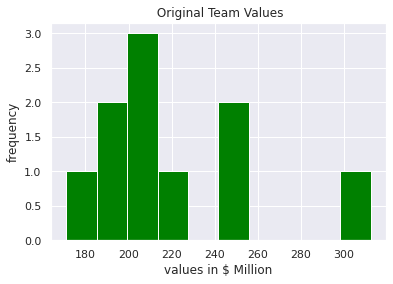

In [ ]:
plt.title (' Original Team Values')
plt.xlabel ('values in $ Million')
plt.ylabel('frequency')
plt.hist(b, color= 'green')
plt.show()

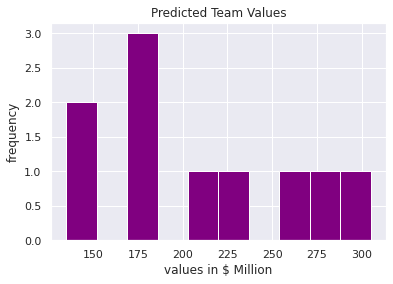

In [ ]:
plt.title ('Predicted Team Values')
plt.xlabel ('values in $ Million')
plt.ylabel('frequency')
plt.hist(a, color= 'purple')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_theme(color_codes=True)
tips = sns.load_dataset("tips")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


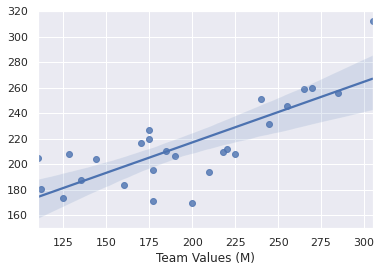

In [ ]:
sns.regplot(lasso_y_test, preds, data=tips);

In [ ]:
##OLS Model minus Shot Accuracy as variable
soccer_ols = sm.OLS(lasso_y_train, scaler.transform(lasso_X_train)).fit()
y_hat_soccer_ols = soccer_ols.predict(scaler.transform((lasso_X_test)))
mse = metrics.mean_squared_error(y_true=lasso_y_test, y_pred=y_hat_soccer_ols)
print('MSE of OLS Regression: ', mse)

MSE of OLS Regression:  50394.911731178865


In [ ]:
##Ridge Model with OLS variables
model_ridge = Ridge() # note we don't need to normalize again
model_ridge.fit(scaler.transform(lasso_X_train), lasso_y_train) # note we transform X_train

preds = model_ridge.predict(scaler.transform((lasso_X_test))) 
predictions_df =  np.append(lasso_y_test, preds)
mse = metrics.mean_squared_error(lasso_y_test, preds)
print('MSE of Ridge Regression: ', mse)


ridge_score = np.mean(cross_val_score(model_ridge, lasso_X_train, lasso_y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of Ridge Regression: ', ridge_score)

MSE of Ridge Regression:  1667.936920017622
Cross Validation Score of Ridge Regression:  0.4271325631270608


In [ ]:
##Elastic Net Model with OLS variables
model_elastic = ElasticNet() # note we don't need to normalize again
model_elastic.fit(scaler.transform(lasso_X_train), lasso_y_train) # note we transform X_train

preds = model_elastic.predict(scaler.transform((lasso_X_test))) 
predictions_df =  np.append(lasso_y_test, preds)
mse = metrics.mean_squared_error(lasso_y_test, preds)
print('MSE of ElasticNet Regression: ', mse)


elastic_score = np.mean(cross_val_score(model_elastic, lasso_X_train, lasso_y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of ElasticNet Regression: ', elastic_score)


MSE of ElasticNet Regression:  1773.6428222027732
Cross Validation Score of ElasticNet Regression:  0.581374351070226


In [ ]:
#Find variables accoring to BIC
X = soccer.drop(['Team Values (M)'], axis = 1)
X = sm.add_constant(X)
soccer_bic = linear_model.LassoLarsIC(criterion='bic', normalize=True)
soccer_bic.fit(X,y)
X.columns[np.abs(soccer_bic.coef_) > 0]

Index(['Cum. Player Value (M)', 'Revenue (M)'], dtype='object')

The variables found by the BIC model include the Cum. Player Value (M) and Revenue (M).

In [ ]:
##Lasso Model with BIC variables
X_BIC = X[['Cum. Player Value (M)', 'Revenue (M)']]
X_train, X_test, y_train, y_test = train_test_split(X_BIC, y, test_size=0.25)
scaler = preprocessing.StandardScaler().fit(X_train)
BIC_model_lassoCV = LassoCV(cv=5, normalize=False) # note we don't need to normalize again
BIC_model_lassoCV.fit(scaler.transform(X_train), y_train) # note we transform X_train

preds = BIC_model_lassoCV.predict(scaler.transform((X_test))) 
predictions_df =  np.append(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
print('MSE of LassoCV Regression: ', mse)


lasso_score = np.mean(cross_val_score(BIC_model_lassoCV, X_train, y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of LassoCV Regression: ', lasso_score)

MSE of LassoCV Regression:  3429.7614814078993
Cross Validation Score of LassoCV Regression:  0.7052568926925422


In [ ]:
##Ridge Model with BIC variables
BIC_model_ridge = Ridge() # note we don't need to normalize again
BIC_model_ridge.fit(scaler.transform(X_train), y_train) # note we transform X_train

preds = BIC_model_ridge.predict(scaler.transform((X_test))) 
predictions_df =  np.append(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
print('MSE of Ridge Regression: ', mse)


ridge_score = np.mean(cross_val_score(BIC_model_ridge, X_train, y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of Ridge Regression: ', ridge_score)

MSE of Ridge Regression:  3530.6406593864567
Cross Validation Score of Ridge Regression:  0.7006122696795627


In [ ]:
##Elastic Net Model with BIC variables
BIC_model_elastic = ElasticNet() # note we don't need to normalize again
BIC_model_elastic.fit(scaler.transform(X_train), y_train) # note we transform X_train

preds = BIC_model_elastic.predict(scaler.transform((X_test))) 
predictions_df =  np.append(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
print('MSE of ElasticNet Regression: ', mse)


elastic_score = np.mean(cross_val_score(BIC_model_elastic, X_train, y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of ElasticNet Regression: ', elastic_score)

MSE of ElasticNet Regression:  2618.7812110679083
Cross Validation Score of ElasticNet Regression:  0.7008316467537662


In [ ]:
## Find Variables According to Recursive Feature Elimination
X = soccer.drop(['Team Values (M)'], axis = 1)
X = sm.add_constant(X)
model = LinearRegression()
model.fit(X, y)
model_RFE = RFE(model, 5)
model_RFE.fit(X, y)
model_RFE.get_support()
X = X.loc[:, model_RFE.get_support()]
X = sm.add_constant(X)
X

,const,Cum. Player Value (M),Average Age,Winning Percentage,Goals per game,Shot Accuracy
0,1.0,69.78,23.7,0.529,1.706,0.114
1,1.0,22.83,25.0,0.294,1.618,0.115
2,1.0,19.83,24.6,0.353,1.706,0.120
3,1.0,26.98,25.4,0.294,1.147,0.099
4,1.0,32.75,24.6,0.382,1.235,0.098
...,...,...,...,...,...,...
98,1.0,8.78,25.2,0.324,1.118,0.102
99,1.0,8.70,25.3,0.441,1.265,0.115
100,1.0,7.83,25.0,0.529,1.529,0.130
101,1.0,7.55,24.6,0.412,1.412,0.124


The variables chosen with Recursive Feature Elimination are Cum. Player Value (M), Average Age, Winning Percentage, Goals per game, and Shot Accuracy.

In [ ]:
##Lasso Model with RFE variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = preprocessing.StandardScaler().fit(X_train)
RFE_model_lassoCV = LassoCV(cv=5, normalize=False) # note we don't need to normalize again
RFE_model_lassoCV.fit(scaler.transform(X_train), y_train) # note we transform X_train

preds = RFE_model_lassoCV.predict(scaler.transform((X_test))) 
predictions_df =  np.append(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
print('MSE of LassoCV Regression: ', mse)


lasso_score = np.mean(cross_val_score(RFE_model_lassoCV, X_train, y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of LassoCV Regression: ', lasso_score)

MSE of LassoCV Regression:  2587.6594073924393
Cross Validation Score of LassoCV Regression:  0.5531233482900236


In [ ]:
##Ridge Model with OLS variables
RFE_model_ridge = Ridge() # note we don't need to normalize again
RFE_model_ridge.fit(scaler.transform(X_train), y_train) # note we transform X_train

preds = RFE_model_ridge.predict(scaler.transform((X_test))) 
predictions_df =  np.append(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
print('MSE of Ridge Regression: ', mse)


ridge_score = np.mean(cross_val_score(RFE_model_ridge, X_train, y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of Ridge Regression: ', ridge_score)

MSE of Ridge Regression:  2527.4139147505457
Cross Validation Score of Ridge Regression:  0.5412492203603148


In [ ]:
##Elastic Net Model with OLS variables
RFE_model_elastic = ElasticNet() # note we don't need to normalize again
RFE_model_elastic.fit(scaler.transform(X_train), y_train) # note we transform X_train

preds = RFE_model_elastic.predict(scaler.transform((X_test))) 
predictions_df =  np.append(y_test, preds)
mse = metrics.mean_squared_error(y_test, preds)
print('MSE of ElasticNet Regression: ', mse)


elastic_score = np.mean(cross_val_score(RFE_model_elastic, X_train, y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of ElasticNet Regression: ', elastic_score)

MSE of ElasticNet Regression:  3306.717057198873
Cross Validation Score of ElasticNet Regression:  0.5461924688618478


Overall using the variables that were significant in the OLS regression had the lowest MSE. Next we can use Grid SearchCV to find the optimal parameters for the linear regressions.

In [ ]:
##Lasso Model with OLS variables & Grid Search

model_lassoCV.get_params()
params = {'n_alphas' : range(1, 150,10)}
tuned_model = GridSearchCV(model_lassoCV, params)
tuned_model.fit(scaler.transform(lasso_X_train), lasso_y_train)
print (tuned_model.best_params_)


ValueError: ignored

In [ ]:
#Lasso Model with Optimal Parameters
model_lassoCV = LassoCV(cv=5, normalize=False, n_alphas = 1)
model_lassoCV.fit(scaler.transform(lasso_X_train), lasso_y_train) # note we transform X_train

preds = model_lassoCV.predict(scaler.transform((lasso_X_test))) 
predictions_df =  np.append(lasso_y_test, preds)
mse = metrics.mean_squared_error(lasso_y_test, preds)
print('MSE of LassoCV Regression: ', mse)


lasso_score = np.mean(cross_val_score(model_lassoCV, lasso_X_train, lasso_y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of LassoCV Regression: ', lasso_score)

ValueError: ignored

In [ ]:
##Ridge Model with OLS variables & GridSearchCV
params = {'alpha' : range(0, 50,1)}
tuned_model = GridSearchCV(model_ridge, params)
tuned_model.fit(scaler.transform(lasso_X_train), lasso_y_train)
print (tuned_model.best_params_)

ValueError: ignored

In [ ]:
#Ridge Model with Optimal Parameters
model_ridge = Ridge(alpha = 8) # note we don't need to normalize again
model_ridge.fit(scaler.transform(lasso_X_train), lasso_y_train) # note we transform X_train

preds = model_ridge.predict(scaler.transform((lasso_X_test))) 
predictions_df =  np.append(lasso_y_test, preds)
mse = metrics.mean_squared_error(lasso_y_test, preds)
print('MSE of Ridge Regression: ', mse)


ridge_score = np.mean(cross_val_score(model_ridge, lasso_X_train, lasso_y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of Ridge Regression: ', ridge_score)

ValueError: ignored

In [ ]:
##Elastic Net Model with OLS variables & Grid Search


model_elastic.get_params()
params =  {'alpha' : range(1, 50,1)}
tuned_model = GridSearchCV(model_elastic, params)
tuned_model.fit(scaler.transform(lasso_X_train), lasso_y_train)
print (tuned_model.best_params_)


ValueError: ignored

In [ ]:
model_elastic = ElasticNet(alpha = 1) # note we don't need to normalize again
model_elastic.fit(scaler.transform(lasso_X_train), lasso_y_train) # note we transform X_train

preds = model_elastic.predict(scaler.transform((lasso_X_test))) 
predictions_df =  np.append(lasso_y_test, preds)
mse = metrics.mean_squared_error(lasso_y_test, preds)
print('MSE of ElasticNet Regression: ', mse)


elastic_score = np.mean(cross_val_score(model_elastic, lasso_X_train, lasso_y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of ElasticNet Regression: ', elastic_score)

ValueError: ignored

The regular Lasso Model without the optimal parameters was the best method. 

In [ ]:
##Graph LassoCV Model
model_lassoCV = LassoCV(cv=5, normalize=False)
model_lassoCV.fit(scaler.transform(lasso_X_train), lasso_y_train) # note we transform X_train

preds = model_lassoCV.predict(scaler.transform((lasso_X_test))) 
predictions_df =  np.append(lasso_y_test, preds)
mse = metrics.mean_squared_error(lasso_y_test, preds)
print('MSE of LassoCV Regression: ', mse)


lasso_score = np.mean(cross_val_score(model_lassoCV, lasso_X_train, lasso_y_train, cv=5))
from sklearn.model_selection import cross_val_score
print('Cross Validation Score of LassoCV Regression: ', lasso_score)

all_data = np.column_stack([lasso_y_test, preds])

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.plot([0, 500], [0, 500], 'k--', label="Random")
plt.scatter(all_data[:,0], all_data[:,1])
model_lassoCV.score(lasso_X_test, lasso_y_test)


ValueError: ignored